# JPEG Compression

Image compression has been around almost as long images were first stored in digital mediums. As digital imaging technologies advanced, the volume of data continued to compete with available storage. This resulted in an ever-present need for methods to reduce the size of images while retaining key features. Utilizing the knowledge of human light sensitivity, compression techniques such as the JPEG standard have allowed images to maintain perceived clarity while requiring only a fraction of the storage space. An overview of the JPEG compression process flow can be described by the figure below.

<br />

![flowchart](./images/JPEG_flowchart.png)

<br />

This notebook aims to create and analyze a simple implementation of the compression pipeline. Characteristics of importance are computing efficiency and compression ratio.

## Converting RGB to YCbCr Format

### Color Space Conversion

The first step in compressing image data from a lossless format such as PNG or TIFF requires converting the colorspace of the data. This data is usually arranged in standard RGB format (after decompression). In this format, there are three channels that control the red, green, and blue values directly. The desired format, Y'CbCr, instead separates the brightness from the color. The **Y'** channel represents the pixel brightness, and the **Cb**/**Cr** channels represent the ratio of red-to-green and blue-to-green, respectively. A plot of the CbCr plane at a fixed luminance value, $Y'=0.5$, is show below.

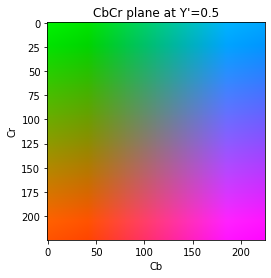

In [59]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

# Using YCrCb instead for cv2 support
yCrCbSpace = np.ndarray((225,225,3), dtype=np.uint8)
chromaRange = np.arange(start=16, stop=241, dtype=np.uint8) # Chroma ranges from 16 to 240
yCrCbSpace[:,:,0] = (235+16)//2 # Luminance ranges from 16 to 235
yCrCbSpace[:,:,1] = chromaRange[:, np.newaxis]
yCrCbSpace[:,:,2] = chromaRange[np.newaxis, :]

rgbSpace = cv2.cvtColor(yCrCbSpace, cv2.COLOR_YCrCb2RGB)

plt.imshow(rgbSpace)
plt.title("CbCr plane at Y'=0.5")
plt.xlabel("Cb")
plt.ylabel("Cr")
plt.show()

The conversion from RGB to YCbCr is standardized according to the JPEG File Interchange Format. According to the ITU-R BT.601 standard (and adjusting for full luminance range), the digital components $D_{Y'}$, $D_{Cb}$, and $D_{Cr}$ can be estimated as follows

$$
D_{Y'} \approx \text{INT}\left[\frac{\text{INT}[0.299 \cdot 2^{m}]}{2^{m}}D_{R} + \frac{\text{INT}[0.587 \cdot 2^{m}]}{2^{m}}D_{G} + \frac{\text{INT}[0.114 \cdot 2^{m}]}{2^{m}}D_{B}\right]
$$
$$
D_{Cb} \approx \text{INT}\left[\frac{\text{INT}\left[-\frac{0.299}{1.772} \cdot \frac{224}{219} \cdot 2^{m}\right]}{2^{m}}D_{R} + \frac{\text{INT}\left[-\frac{0.587}{1.772} \cdot \frac{224}{219} \cdot 2^{m}\right]}{2^{m}}D_{G} + \frac{\text{INT}\left[\frac{0.886}{1.772} \cdot \frac{224}{219} \cdot 2^{m}\right]}{2^{m}}D_{B} + 2^{n-1}\right]
$$
$$
D_{Cr} \approx \text{INT}\left[\frac{\text{INT}\left[\frac{0.701}{1.402} \cdot \frac{224}{219} \cdot 2^{m}\right]}{2^{m}}D_{R} + \frac{\text{INT}\left[-\frac{0.587}{1.402} \cdot \frac{224}{219} \cdot 2^{m}\right]}{2^{m}}D_{G} + \frac{\text{INT}\left[-\frac{0.114}{1.402} \cdot \frac{224}{219} \cdot 2^{m}\right]}{2^{m}}D_{B} + 2^{n-1}\right]
$$

where $m$ is the bit-length of the integer coefficients and $n$ is the bit-depth of the image data. As $m$ increases, the equation converges on the actual value of each component. 

In [60]:
from ipywidgets import interact
import ipywidgets as widgets

def convertYCbCr(inputImage, m = 1):
    """Convert RGB image to Y'CbCr format

    Parameters
    ----------
    inputImage : ndarray
        3-dimensional RGB input image.
    m : int
        Bit-length of the conversion coefficients. If zero, calculate Y'CbCr values as floats.

    Returns
    -------
    ndarray
        Array of same dimensions as inputImage with Y'CbCr image data. If m is zero, this is
        an array of type float, else it is an array of type uint8

    """
    scale = int(2**m)
    coeffY_R = 0.299 * scale
    coeffY_G = 0.587 * scale
    coeffY_B = 0.114 * scale
    coeffCb_R = (-0.299/1.772) * (224/219) * scale
    coeffCb_G = (-0.587/1.772) * (224/219) * scale
    coeffCb_B = (0.886/1.772) * (224/219) * scale
    coeffCr_R = (0.701/1.402) * (224/219) * scale
    coeffCr_G = (-0.587/1.402) * (224/219) * scale
    coeffCr_B = (-0.114/1.402) * (224/219) * scale
    
    convMat = np.array([[coeffY_R,  coeffY_G,  coeffY_B ],
                        [coeffCb_R, coeffCb_G, coeffCb_B],
                        [coeffCr_R, coeffCr_G, coeffCr_B]])
    
    if m != 0:
        convMat = convMat.astype(int)
    
    # Multiply RGB values by Coefficients
    tmpIm = np.einsum('ijk,hk->ijh', inputImage, convMat)
    if m == 0:
        return np.add(tmpIm, np.array([0, 128, 128]))
    else:
        # Divide by 2^m
        np.right_shift(tmpIm, m, out=tmpIm)
        # Add chroma offsets
        return np.add(tmpIm, np.array([0, 128, 128])).astype(np.uint8)
        

In [61]:
im = cv2.cvtColor(cv2.imread("./images/misc/mandrill.tiff"), cv2.COLOR_BGR2RGB)
assert im.shape[2] == 3, "Wrong number of image channels"
        
def displayConverted(bitLength):
    """Display color converted image for coefficients of m bit-length"""
    convIm = convertYCbCr(im, bitLength)
    # Cannot display as YCbCr, so instead convert back to RGB
    plt.imshow(cv2.cvtColor(convIm[:,:,[0,2,1]], cv2.COLOR_YCrCb2RGB))
    plt.title("Image Converted to Y'CbCr")
    plt.show()

interact(displayConverted, bitLength=widgets.IntSlider(min=1, max=10, step=1, value=8))

interactive(children=(IntSlider(value=8, description='bitLength', max=10, min=1), Output()), _dom_classes=('wi…

<function __main__.displayConverted(bitLength)>

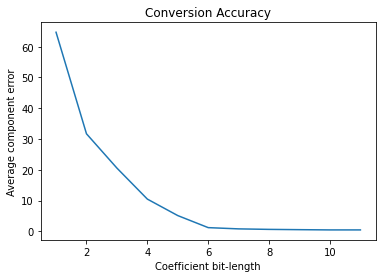

In [62]:
# Compute average difference from reference image across coefficient bit-lengths
diffAvg = []
floatIm = convertYCbCr(im, 0)
for m in range(1,12):
    convIm = convertYCbCr(im, m)
    diffAvg.append(np.divide(np.sum(np.abs(np.subtract(floatIm, convIm))), im.size))
    
plt.plot(range(1,12), diffAvg)
plt.title("Conversion Accuracy")
plt.xlabel("Coefficient bit-length")
plt.ylabel("Average component error")
plt.show()

### Chroma Subsampling

Now that the brightness is has been separated into it's own component, the chromatic detail can be reduced independently. JPEG images traditionally use the Y'CbCr 4:2:0 subsampling rate. In the format, the chromatic components are subsampled in both the horizontal and vertical directions. This implementation will average neighboring chroma values to create interstitial subsamples.

## Discrete Cosine Transform

The next step in the JPEG process involves utilizing the 2-dimensional Discrete Cosine Transform to represent the image data in the frequency domain. Since high-frequency changes in brightness are difficult to perceive, that portion of the image data can be significantly compressed without severe degradation. Typical JPEG implementations of the DCT consist of three steps:

1. Splitting the image into 8x8 blocks
2. Performing a type-II DCT on each block
3. Quantizing the output

### Block Splitting

In order to balance compression rate versus processing time, the DCT is usually performed on 8x8 blocks. Since the chroma components are now subsampled, this no longer directly corresponds to a group of 8x8 pixels. To resolve this issue, the concept of a Minimum Coded Unit arises. An MCU contains the minimum amount of data necessary to recreate a group of pixels after encoding. An 8x8 block of chroma values contains color information for 16x16 pixels, so the MCU for Y'CbCr 4:2:0 would be 16x16. This MCU can be split into four quadrants of 8x8 luminance blocks. Combining the data from all four luminance quadrants and each chroma channel therefore provides enough information to reproduce 16x16 pixels.

For the purposes of this project, the base array of Y'CbCr will be decomposed into a smaller array of MCUs organized with the $Y'$ quadrants first.

<br />

![block splitting](./images/Block_Splitting.png)

<br />

In [63]:
def block420(inputImage):
    """Split image into 16x16 MCUs based on Y'CbCr 4:2:0 sampling
    
    Parameters
    ----------
    inputImage : ndarray
        3-dimensional Y'CbCr input image.
    
    Returns
    -------
    ndarray
        Multidimensional array of 16x16 MCUs arranged in Y'00, Y'01, Y'10, Y'11, Cb, Cr format
    """
    
    # Round up to 16, then divide by 16
    outWidth = ((inputImage.shape[0] + 15) & ~15) >> 4
    outHeight = ((inputImage.shape[1] + 15) & ~15) >> 4
    
    # Create output array
    outMCU = np.ndarray((outWidth,outHeight,6,8,8), dtype=np.uint8)
    
    # Pad input image if necessary
    if inputImage.shape[0] != (outWidth<<4) or inputImage.shape[1] != (outHeight<<4):
        padWidth = (outWidth<<4) - inputImage.shape[0]
        padHeight = (outHeight<<4) - inputImage.shape[1]
        inputImage = np.pad(inputImage, ((0,padWidth),(0,padHeight),(0,0)), mode='edge')
    
    # Simple loop over each MCU
    # TODO: optimize this
    for i in range(0, outWidth):
        for j in range(0, outHeight):
            iMCU = i*16
            jMCU = j*16
            # Y'00
            outMCU[i][j][0] = inputImage[iMCU:iMCU+8,jMCU:jMCU+8,0]
            # Y'01
            outMCU[i][j][1] = inputImage[iMCU:iMCU+8,jMCU+8:jMCU+16,0]
            # Y'10
            outMCU[i][j][2] = inputImage[iMCU+8:iMCU+16,jMCU:jMCU+8,0]
            # Y'11
            outMCU[i][j][3] = inputImage[iMCU+8:iMCU+16,jMCU+8:jMCU+16,0]
            # Cb
            outMCU[i][j][4] = ((inputImage[iMCU:iMCU+16:2,jMCU:jMCU+16:2,1]
                               +inputImage[iMCU+1:iMCU+17:2,jMCU+1:jMCU+17:2,1])
                              // 2)
            # Cr
            outMCU[i][j][5] = ((inputImage[iMCU:iMCU+16:2,jMCU:jMCU+16:2,1]
                               +inputImage[iMCU+1:iMCU+17:2,jMCU+1:jMCU+17:2,1])
                              // 2)
    return outMCU
    
convIm = convertYCbCr(im, 8)
blockIm = block420(convIm)

### Type-II DCT

Now that image data is arranged in 8x8 blocks, the values can be level-shifted into the [-128,127] range and the 8-point Type-II Discrete Cosine Transform can be applied to each block. The DCT functions similarly to the Discrete Fourier Transform in that it utilizes the sum of sinusoids to represent the input signal. However, the DCT only uses cosine elements in its Fourier Series. This has implications on the boundary conditions of the operation, which allows for faster convergence of the Fourier Series. In other words, the signal can be accurately represented in the frequency domain with fewer coefficients when compared to the DFT. The explicit boundary conditions of the DCT can be separated into eight "types". The most common of these, Type-II, implies the input signal, $x_n$, is even around $n=-1/2$ and $n=N-1/2$. The 2-dimensional Type-II DCT coefficients can be described with the following equation adapted from Eric Roberts' [Lossy JPEG](https://cs.stanford.edu/people/eroberts/courses/soco/projects/data-compression/lossy/jpeg/dct.htm) notes from Stanford University.

$$
G_{u,v} = \frac{1}{\sqrt{2N}}C(u)C(v)\sum^{N-1}_{x=0}\sum^{N-1}_{y=0}g_{x,y}\cos\left[\frac{(2x+1)u\pi}{2N}\right]\cos\left[\frac{(2y+1)v\pi}{2N}\right]
$$
$$
C(x) = \left\{ 
  \begin{array}{ c l }
    \frac{1}{\sqrt{2}}, & \: \text{if } x = 1 \\
    1,                 & \: \text{otherwise}
  \end{array}
\right.
$$

where $g_{x,y}$ is the pixel value at that index. The software implementation that follows does not make any of the optimizations used for the Fast Fourier Transform (i.e. matrix factorization into 2-point DFTs).

In [64]:
# Create cosine look up table
x = np.arange(0,8)
uPi = np.pi * np.arange(0,8)
cosLut = np.cos((2*x[:,np.newaxis]+1)*uPi[np.newaxis,:] / 16)

coeff = np.ones((8,8))
coeff[:,0] /= np.sqrt(2)
coeff[0,:] /= np.sqrt(2)

def type2dct(block):
    """Perform 8-point Type-II Discrete Cosine Transform on input"""
    G = np.ndarray(block.shape, dtype=float)
    for u in range(0,8):
        for v in range(0,8):
            # Create cosine matrix for fixed u,v
            cosMat = np.outer(cosLut[:,u],cosLut[:,v]) # Dimensions of (x,y)
            # Sum over x and y
            G[u,v] = np.sum(block*cosMat)
    G = (G*coeff) / 4
    return G

In [65]:
from scipy.fft import dctn

testBlock = blockIm[0,0,0,:,:].astype(int) - 128

# Use Scipy DCT as comparison
testOutput = dctn(testBlock, norm="ortho", overwrite_x=True)

dctOut = type2dct(testBlock)

assert np.allclose(testOutput, dctOut)

### TODO: Quantization

Separate luminance/chrominance quantization tables as per Independent JPEG Group implementation at quality, $q = 50$. 

In [66]:
lumaQuantTbl = np.array([[16,  11,  10,  16,  24,  40,  51,  61],
                         [12,  12,  14,  19,  26,  58,  60,  55],
                         [14,  13,  16,  24,  40,  57,  69,  56],
                         [14,  17,  22,  29,  51,  87,  80,  62],
                         [18,  22,  37,  56,  68, 109, 103,  77],
                         [24,  35,  55,  64,  81, 104, 113,  92],
                         [49,  64,  78,  87, 103, 121, 120, 101],
                         [72,  92,  95,  98, 112, 100, 103,  99]])

chromaQuantTbl = np.array([[16,  18,  24,  47,  99,  99,  99,  99],
                           [18,  21,  26,  66,  99,  99,  99,  99],
                           [24,  26,  56,  99,  99,  99,  99,  99],
                           [47,  66,  99,  99,  99,  99,  99,  99],
                           [99,  99,  99,  99,  99,  99,  99,  99],
                           [99,  99,  99,  99,  99,  99,  99,  99],
                           [99,  99,  99,  99,  99,  99,  99,  99],
                           [99,  99,  99,  99,  99,  99,  99,  99]])

def scaleTblQuality(table, factor):
    """Scale Quantization table by quality factor"""
    if factor <= 0:
        factor = 1
    if factor > 100:
        factor = 100
        
    if factor < 50:
        scale = 5000 / factor
    else:
        scale = 200 - factor*2
    
    scaledTbl = (table*scale + 50) // 100
    scaledTbl[scaledTbl == 0] = 1
    return scaledTbl

In [67]:
def displayQuantTbl(quality):
    print(scaleTblQuality(lumaQuantTbl,quality))

interact(displayQuantTbl, quality=widgets.IntSlider(min=0, max=100, step=1, value=50))

interactive(children=(IntSlider(value=50, description='quality'), Output()), _dom_classes=('widget-interact',)…

<function __main__.displayQuantTbl(quality)>

## TODO: Entropy Encoding

This part of the compression process is lossless. The overall encoding process is as follows:

1. Convert DC coefficients
2. Traverse each block in zig-zag pattern
3. Perform Run-Length and Huffman Encoding

![Huffman](./images/Run_Length.png)

In [68]:
def zigZag(block):
    """Generator to traverse 2-dimensional array in a zig-zag pattern"""
    idx = 0
    x = 0
    y = 0
    topRight = True # Headed in direction towards top right
    while idx < block.size:
        yield block[x,y]
        idx += 1
        
        if topRight:
            if y == block.shape[1]-1:
                x += 1
                topRight = False
            elif x == 0:
                y += 1
                topRight = False
            else:
                x -= 1
                y += 1
        else:
            if x == block.shape[0]-1:
                y += 1
                topRight = True
            elif y == 0:
                x += 1
                topRight = True
            else:
                y -= 1
                x += 1

In [69]:
def encodeBlock(block, huffTbl):
    """Encode block values with Run-Length and Huffman Table"""
    
    encoded = bytearray() # This might need to be a bitstring
    runLen = 0
    size = 0
    for amp in zigZag(block):
        if amp == 0:
            runLen += 1
            if runLen == 16:
                encoded.append(b'\xF0') # Special encoding for run-length overflow
                runLen = 0
        else:
            continue
            # sym2 = huffTbl[amp]
            # sym1 = (runLen << 4) + sym2.bit_length # Run-length and amplitude bit-length fit on one byte
            # Append value in bits
    encoded.append(b'\x00\x00') # End of block
    return encoded

In [70]:
def encodeJPEG(inputImage, bitLength, quality):
    """Encode RGB image to JPEG"""
    
    # Convert from RGB to Y'CbCr
    imYCbCr = convertYCbCr(inputImage, bitLength)
    
    # Chroma subsampling and 8x8 blocking
    blockIm = block420(imYCbCr)
    
    # Process each 8x8 block
    # Looping could possibly be handled by nditer
    for i in range(blockIm.shape[0]):
        for j in range(blockIm.shape[1]):
            for k in range(blockIm.shape[2]):
                # Type-II DCT
                blockDct = type2dct(blockIm[i,j,k,:,:].astype(int) - 128)
                
                if k <= 3:
                    table = lumaQuantTbl
                else:
                    table = chromaQuantTbl
                    
                # Quantize DCT output
                scaledDct = np.rint(blockDct / scaleTblQuality(table, quality))
                
                # TODO: correlate DC coefficients
                # TODO: perform zigzag run-length encoding on AC coefficients
                # encodeBlock(scaledDct)
                
    # TODO: Should return JPEG filename

In [71]:
def interactEncode(filename, bitLength, quality):
    im = cv2.cvtColor(cv2.imread("./images/misc/{}.tiff".format(filename)), cv2.COLOR_BGR2RGB)
    assert im.shape[2] == 3, "Wrong number of image channels"
    
    plt.imshow(im)
    plt.title("Input Image")
    plt.show()
    
    encodeJPEG(im, bitLength, quality)
    
    # TODO: compare file size
    # TODO: show JPEG

In [72]:
interact(interactEncode,
         filename=widgets.Dropdown(options=['airplane', 'house', 'mandrill', 'peppers', 'sailboat', 'splash'],
                                   value='mandrill',
                                   description='Image:',
                                   disabled=False,),
         bitLength=widgets.IntSlider(min=1, max=10, step=1, value=8),
         quality=widgets.IntSlider(min=0, max=100, step=1, value=50))

interactive(children=(Dropdown(description='Image:', index=2, options=('airplane', 'house', 'mandrill', 'peppe…

<function __main__.interactEncode(filename, bitLength, quality)>